## Efficientnet Model

#### Loading Libraries 

In [1]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

#### Loading the data

In [2]:
# !mkdir ./LungColon

# print('Copying files...')
# !cp -R lung_colon_image_set/colon_image_sets/* ./LungColon
# !cp -R lung_colon_image_set/lung_image_sets/* ./LungColon
# print('All files copied successfully!')

In [3]:
folders = glob('./LungColon' + '/*')
print('New Paths: ', folders)

IMAGE_FILES = glob('./LungColon' + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))


New Paths:  ['./LungColon\\colon_aca', './LungColon\\colon_n', './LungColon\\lung_aca', './LungColon\\lung_n', './LungColon\\lung_scc']
Images Count:  20000


#### Display images 

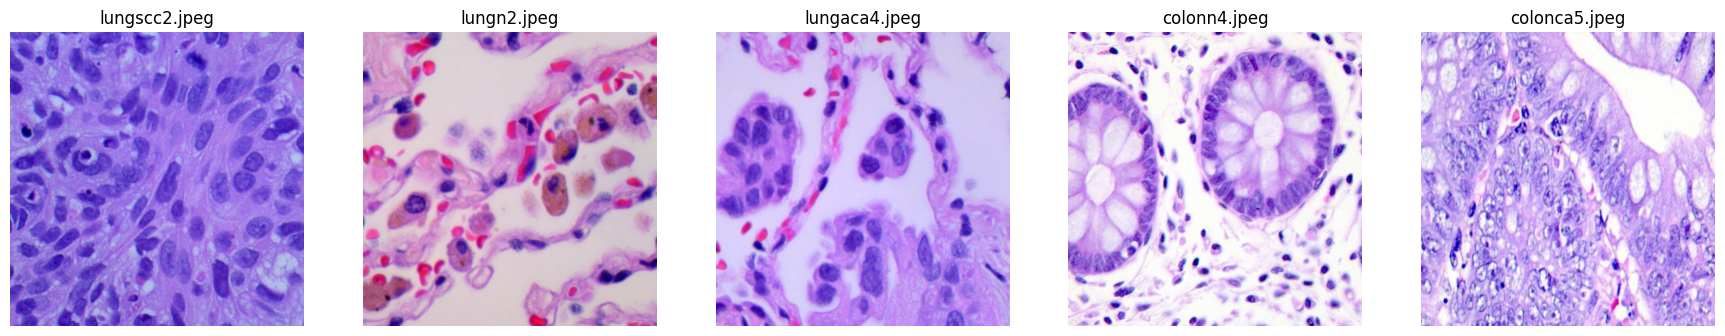

In [4]:
SAMPLES = ['./LungColon/lung_scc/lungscc2.jpeg', './LungColon/lung_n/lungn2.jpeg', 
           './LungColon/lung_aca/lungaca4.jpeg', './LungColon/colon_n/colonn4.jpeg', 
           './LungColon/colon_aca/colonca5.jpeg']

plt.figure(figsize=(22, 8)) 
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.title(t[3])
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

#### Trainig Data

In [14]:
data_dir = './LungColon'

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.2, preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                            rotation_range=20,
                            width_shift_range=0.2,
                            height_shift_range=0.2,)

BATCH_SIZE = 32

X = Y = 100

train_ds = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

Found 16000 images belonging to 5 classes.


#### Validation Data

In [15]:
validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 4000 images belonging to 5 classes.


#### Build The Model

In [16]:
ptm = PretrainedModel(
    input_shape=(X, Y, 3),
    weights='imagenet',
    include_top=False)

ptm.trainable = False

K = len(folders)

x = GlobalAveragePooling2D()(ptm.output)
# x = Flatten()(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)

y = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=y)


In [17]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 100, 100, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 100, 100, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 100, 100, 3)          0         ['normalization_1[0][0]'

                                                                                                  
 block1a_activation (Activa  (None, 50, 50, 64)           0         ['block1a_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block1a_se_squeeze (Global  (None, 64)                   0         ['block1a_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block1a_se_reshape (Reshap  (None, 1, 1, 64)             0         ['block1a_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block1a_s

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_ds,
    validation_data=validation,
    epochs=10,
    callbacks=[early_stopping])


Epoch 1/10
500/500 [==============================] - 1164s 2s/step - loss: 0.9101 - accuracy: 0.6681 - val_loss: 0.5074 - val_accuracy: 0.8360
Epoch 2/10
500/500 [==============================] - 1136s 2s/step - loss: 0.5143 - accuracy: 0.8141 - val_loss: 0.4598 - val_accuracy: 0.8165
Epoch 3/10
500/500 [==============================] - 1134s 2s/step - loss: 0.4445 - accuracy: 0.8369 - val_loss: 0.3912 - val_accuracy: 0.8490
Epoch 4/10
500/500 [==============================] - 1132s 2s/step - loss: 0.4027 - accuracy: 0.8496 - val_loss: 0.3034 - val_accuracy: 0.8953
Epoch 5/10
500/500 [==============================] - 1132s 2s/step - loss: 0.3562 - accuracy: 0.8675 - val_loss: 0.3454 - val_accuracy: 0.8695
Epoch 6/10
500/500 [==============================] - 1136s 2s/step - loss: 0.3430 - accuracy: 0.8743 - val_loss: 0.2797 - val_accuracy: 0.8992
Epoch 7/10
500/500 [==============================] - 4797s 10s/step - loss: 0.3106 - accuracy: 0.8854 - val_loss: 0.2668 - val_accuracy

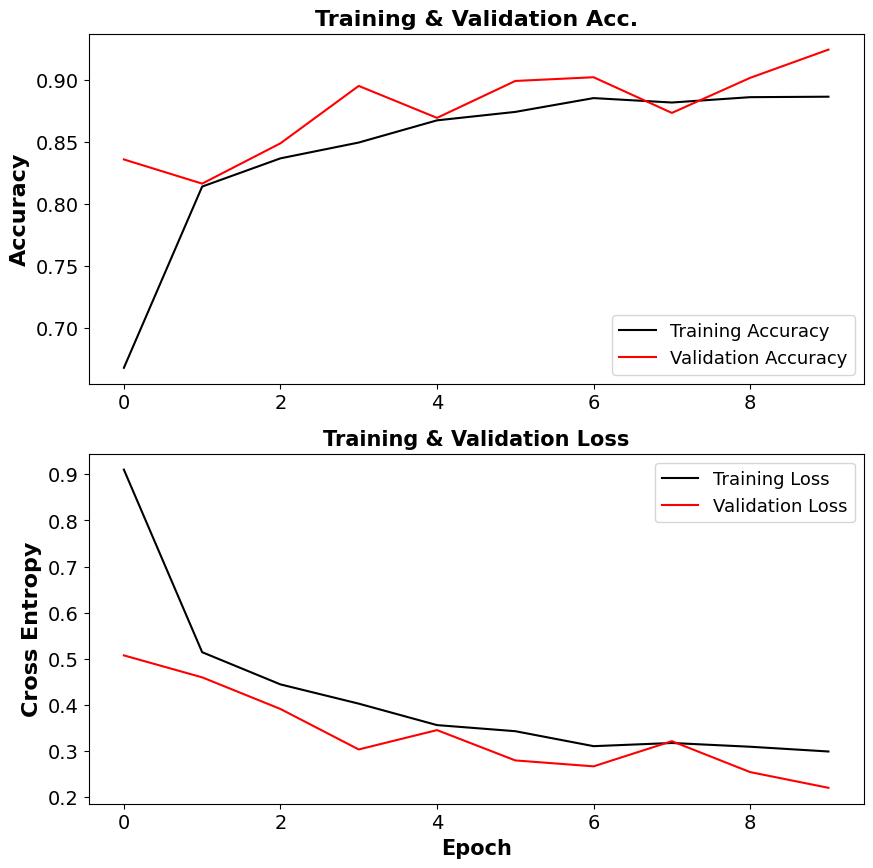

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='black')
plt.plot(val_acc, label='Validation Accuracy', color='red')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='black')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()


#### Classification_report

In [20]:
from sklearn.metrics import classification_report

Y_pred = model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))


125/125 [==============================] - 223s 2s/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       800
           1       0.98      0.96      0.97       800
           2       0.81      0.88      0.84       800
           3       0.97      0.96      0.97       800
           4       0.91      0.87      0.89       800

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000




#### Compute confusion matrix

<Axes: >

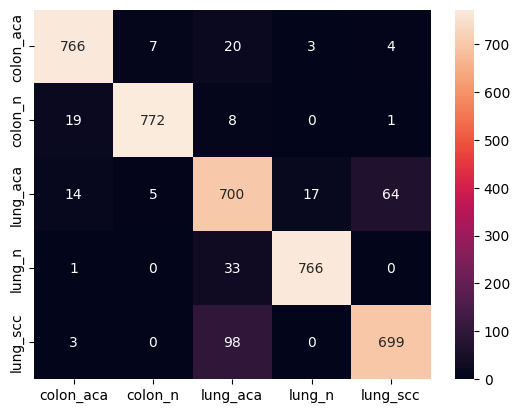

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

labels = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
sns.heatmap(confusion_matrix(validation.classes,y_pred),annot=True,fmt='d',xticklabels=labels,yticklabels=labels)

In [22]:
model.save("efficientnet.h5")

c:\Users\abi\Desktop\abijith\DeepLearning\DL\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
